In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
import os
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if USE_CUDA else "cpu")
print(DEVICE)

cuda:0


In [2]:
classes = os.listdir("CAPTCHA_IMAGES")
print(classes)

['motorcycle', 'seaplane', 'boat', 'motorbus', 'bicycle', 'train', 'truck', 'airplane']


In [3]:
labels = os.listdir("CAPTCHA_IMAGES_SPLIT/train")
print(labels)

['motorcycle', 'seaplane', 'boat', 'motorbus', 'bicycle', 'train', 'truck', 'airplane']


In [4]:
import pandas as pd

names=[]
num_train=[]
num_test=[]
num_total = []

for name in labels:
    image_number_train = len(os.listdir(f"CAPTCHA_IMAGES_SPLIT/train/{name}"))
    image_number_test = len(os.listdir(f"CAPTCHA_IMAGES_SPLIT/val/{name}"))
    
    names.append(name)
    num_train.append(image_number_train)
    num_test.append(image_number_test)
    num_total.append(image_number_train+image_number_test)
dic = {'Label': names, 'Number(training)': num_train, 'Number(testing)': num_test, 'Total': num_total} 
    
df = pd.DataFrame(dic)
df

,Label,Number(training),Number(testing),Total
0,motorcycle,733,0,733
1,seaplane,355,0,355
2,boat,662,0,662
3,motorbus,317,0,317
4,bicycle,375,0,375
5,train,304,0,304
6,truck,819,0,819
7,airplane,504,0,504


In [5]:
print(f"Total training images: {df['Number(training)'].sum()}")
print(f"Total testing images: {df['Number(testing)'].sum()}")

Total training images: 4069
Total testing images: 0


img.shape  (128, 128, 3)
height  128
width  128
channel  3


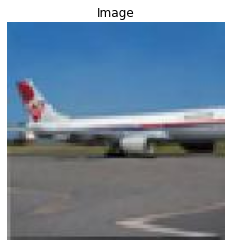

In [7]:
##Data information
#Height : 128
#Weight : 128
#Channel : 3

import numpy as np
import cv2


img = cv2.imread('CAPTCHA_IMAGES_SPLIT/train/airplane/1650199961986_0.jpg', cv2.IMREAD_COLOR)

print('img.shape ', img.shape)


h, w, c = img.shape

print('height ', h)
print('width ', w)
print('channel ', c)

# OpenCV는 BGR 포맷을 사용하므로 RGB로 변환
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# matplotlib를 이용해 이미지 표시
plt.imshow(img_rgb)
plt.title('Image')  # 이미지 제목 설정
plt.axis('off')  # 축 제거
plt.show()

In [8]:
class CUB_CAPTCHA(Dataset):
    def __init__(self, transform, mode='train', target_class = 'airplane'):
        self.transform = transform
        self.mode = mode
        base_path = 'CAPTCHA_IMAGES_SPLIT'  # 기본 경로 설정

        if self.mode == 'train':
            folder_path = os.path.join(base_path, 'train')
        elif self.mode == 'valid':
            folder_path = os.path.join(base_path, 'val')
        
        
        # 모든 하위 폴더의 파일을 포함
        self.image_paths = []
        self.labels = []

        for class_name in os.listdir(folder_path):
            if class_name not in target_class:
                continue
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    if os.path.isfile(img_path):  # 파일만 추가
                        self.image_paths.append(img_path)
                        self.labels.append(class_name)  # 클래스명으로 라벨 설정

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        # 라벨을 클래스 이름에서 추출
        label = self.labels[idx]

        # 문자열 라벨을 숫자로 매핑
        label_map = {  # 클래스 이름을 정수로 매핑
            'motorcycle': 0, 'seaplane': 1, 'boat': 2, 'motorbus': 3,
            'bicycle': 4, 'train': 5, 'truck': 6, 'airplane': 7
        }
        label = label_map[label]

        return img, label


In [9]:
# 데이터 변환 정의
'''transforms_train = transforms.Compose([
    transforms.Resize((448, 448)),              # 크기 조정
    transforms.RandomRotation(15),              # 무작위 회전
    transforms.RandomResizedCrop(448, scale=(0.8, 1.0)),  # 무작위 크롭
    transforms.RandomHorizontalFlip(p=0.5),     # 좌우 반전
    transforms.ToTensor(),                      # 텐서 변환
])'''

transforms_augmentation = transforms.Compose([
    transforms.Resize((64, 64)),              # 크기 조정
    transforms.RandomRotation(15),              # 무작위 회전
    transforms.RandomHorizontalFlip(p=0.5),     # 좌우 반전
    transforms.ToTensor(),                      # 텐서 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 픽셀 값을 [-1, 1]로 정규화
])

transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),              # 크기 조정
    transforms.ToTensor(),                      # 텐서 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 픽셀 값을 [-1, 1]로 정규화
])

In [22]:
'''BATCH_SIZE = 32

train_set = CUB_CAPTCHA(mode='train', transform=transforms_train) 
augmentation_set = CUB_CAPTCHA(mode='train', transform=transforms_augmentation)

CAPTCHA_train_set = ConcatDataset([train_set, augmentation_set])

train_loader = DataLoader(CAPTCHA_train_set, batch_size=BATCH_SIZE, shuffle=True)

print('Num of each dataset:', len(train_set), len(augmentation_set), len(CAPTCHA_train_set))
print("Loaded combined dataloader")'''

Num of each dataset: 503 503 1006
Loaded combined dataloader


In [13]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 여러 샘플 이미지와 라벨 시각화 함수
def show_samples_from_loader(loader, num_samples=10, cols=5):
    rows = (num_samples + cols - 1) // cols  # 필요한 행 계산
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    # 첫 번째 배치에서 데이터 가져오기
    data_iter = iter(loader)
    images, labels = next(data_iter)  # 배치에서 이미지와 라벨 가져오기

    for i in range(num_samples):
        if i >= len(images):  # 배치 크기를 초과하면 종료
            break

        # 이미지를 0-1 범위로 변환 후 PIL 이미지로 변환
        img = to_pil_image(0.5 * images[i] + 0.5)  # Normalize 해제 (if normalized)

        # 현재 subplot에 이미지 표시
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')  # 축 제거

    # 남은 빈 공간 subplot 제거
    for j in range(num_samples, rows * cols):
        if rows > 1:
            axes[j // cols, j % cols].axis('off')
        else:
            axes[j % cols].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.gan = nn.Sequential(
            nn.ConvTranspose2d(noise_size,512, kernel_size=4, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512 ,256, kernel_size=4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256,128, kernel_size=4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128,64, kernel_size=4, stride = 2, padding = 1,bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64,3,kernel_size = 4, stride = 2, padding = 1, bias = False),
            
            nn.Tanh()
        )

    def forward(self, x):
        return self.gan(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
      
        # 감별자를 구성하는 층의 정의
        self.disc = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.LeakyReLU(0.2),

           nn.Conv2d(64, 128, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.LeakyReLU(0.2),

           nn.Conv2d(128, 256, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.LeakyReLU(0.2),

           nn.Conv2d(256, 512, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(512),
           nn.LeakyReLU(0.2),

           nn.Conv2d(512, 1, kernel_size=4),
           nn.Sigmoid()
       )

    def forward(self, x):
        return self.disc(x)

In [14]:
def weights_init(m):
    # 층의 종류 추출
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # 합성곱층 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # 배치정규화층 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
def make_synthesize_img(label):
    save_path = label
    os.makedirs(save_path, exist_ok=True)
    return save_path

In [22]:
def make_dataset(target_class):
    BATCH_SIZE = 32

    train_set = CUB_CAPTCHA(mode='train', transform=transforms_train, target_class = target_class) 
    augmentation_set = CUB_CAPTCHA(mode='train', transform=transforms_augmentation, target_class = target_class)

    CAPTCHA_train_set = ConcatDataset([train_set, augmentation_set])

    train_loader = DataLoader(CAPTCHA_train_set, batch_size=BATCH_SIZE, shuffle=True)

    print('Num of each dataset:', len(train_set), len(augmentation_set), len(CAPTCHA_train_set))
    print("Loaded combined dataloader")
    
    return train_loader

Num of each dataset: 733 733 1466
Loaded combined dataloader


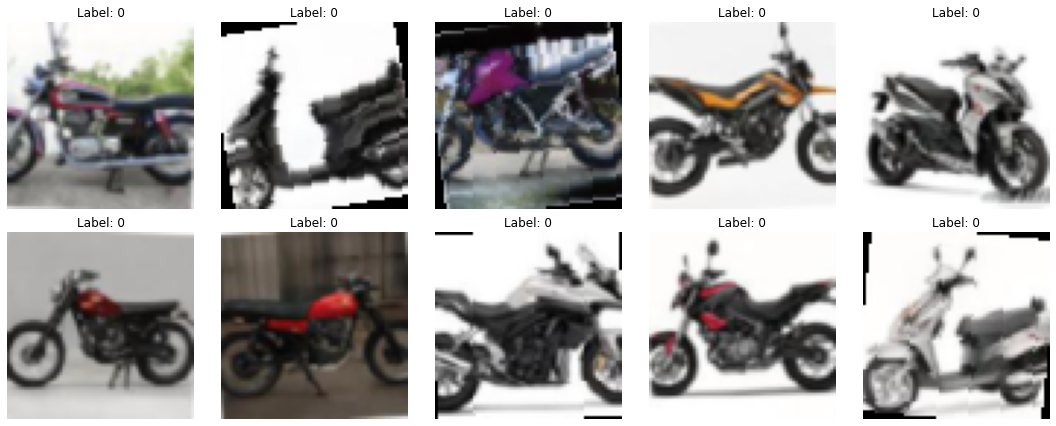

[Epoch 1/200] [Batch 0/46] [D loss: 0.6799] [G loss: 2.5512]
[Epoch 1/200] [Batch 32/46] [D loss: 0.1918] [G loss: 17.0659]
[Epoch 2/200] [Batch 0/46] [D loss: 0.6247] [G loss: 14.7509]
[Epoch 2/200] [Batch 32/46] [D loss: 0.0303] [G loss: 9.6482]
[Epoch 3/200] [Batch 0/46] [D loss: 0.0179] [G loss: 5.6848]
[Epoch 3/200] [Batch 32/46] [D loss: 0.0671] [G loss: 3.8653]
[Epoch 4/200] [Batch 0/46] [D loss: 0.8873] [G loss: 12.7292]
[Epoch 4/200] [Batch 32/46] [D loss: 0.2387] [G loss: 4.8427]
[Epoch 5/200] [Batch 0/46] [D loss: 0.1829] [G loss: 4.3898]
[Epoch 5/200] [Batch 32/46] [D loss: 0.0551] [G loss: 6.6967]
[Epoch 6/200] [Batch 0/46] [D loss: 0.2057] [G loss: 7.1981]
[Epoch 6/200] [Batch 32/46] [D loss: 0.1278] [G loss: 3.9280]
[Epoch 7/200] [Batch 0/46] [D loss: 0.1426] [G loss: 4.6179]
[Epoch 7/200] [Batch 32/46] [D loss: 0.0988] [G loss: 4.2882]
[Epoch 8/200] [Batch 0/46] [D loss: 0.2159] [G loss: 7.5083]
[Epoch 8/200] [Batch 32/46] [D loss: 0.3239] [G loss: 4.7535]
[Epoch 9/200]

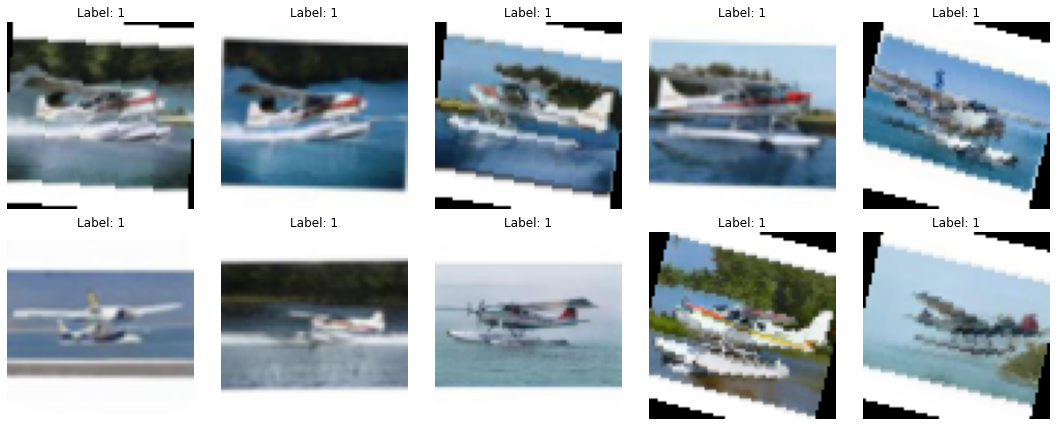

[Epoch 1/200] [Batch 0/23] [D loss: 0.7400] [G loss: 3.6025]
[Epoch 2/200] [Batch 0/23] [D loss: 0.0302] [G loss: 8.2251]
[Epoch 3/200] [Batch 0/23] [D loss: 0.0406] [G loss: 10.7281]
[Epoch 4/200] [Batch 0/23] [D loss: 0.1760] [G loss: 10.4994]
[Epoch 5/200] [Batch 0/23] [D loss: 0.0251] [G loss: 11.1518]
[Epoch 6/200] [Batch 0/23] [D loss: 0.0136] [G loss: 9.1314]
[Epoch 7/200] [Batch 0/23] [D loss: 0.0136] [G loss: 6.9032]
[Epoch 8/200] [Batch 0/23] [D loss: 0.0114] [G loss: 6.9772]
[Epoch 9/200] [Batch 0/23] [D loss: 0.0134] [G loss: 8.1764]
[Epoch 10/200] [Batch 0/23] [D loss: 0.0135] [G loss: 7.0275]
[Epoch 11/200] [Batch 0/23] [D loss: 0.0316] [G loss: 5.4480]
[Epoch 12/200] [Batch 0/23] [D loss: 0.1655] [G loss: 11.4429]
[Epoch 13/200] [Batch 0/23] [D loss: 0.1198] [G loss: 8.0640]
[Epoch 14/200] [Batch 0/23] [D loss: 0.0539] [G loss: 7.1443]
[Epoch 15/200] [Batch 0/23] [D loss: 0.0014] [G loss: 7.7005]
[Epoch 16/200] [Batch 0/23] [D loss: 0.1666] [G loss: 11.6322]
[Epoch 17/20

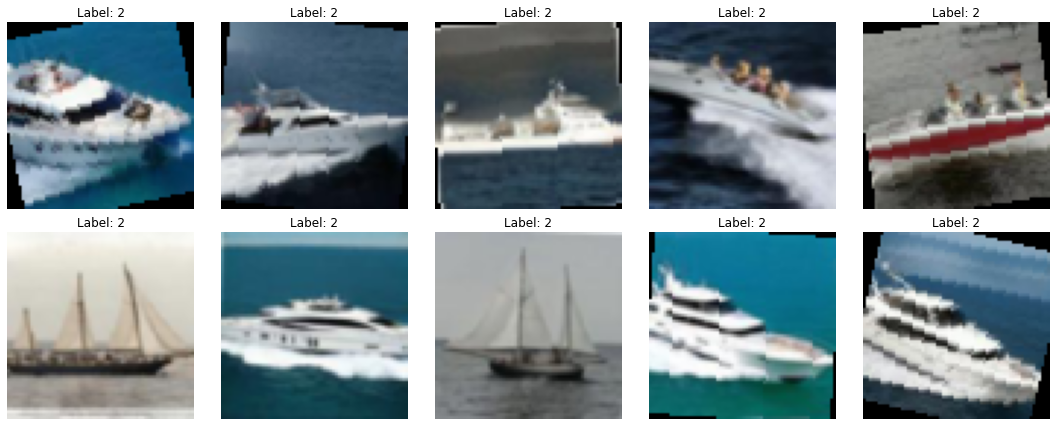

[Epoch 1/200] [Batch 0/42] [D loss: 0.6483] [G loss: 3.5622]
[Epoch 1/200] [Batch 32/42] [D loss: 0.0466] [G loss: 10.1475]
[Epoch 2/200] [Batch 0/42] [D loss: 0.1177] [G loss: 13.6525]
[Epoch 2/200] [Batch 32/42] [D loss: 0.2683] [G loss: 10.6476]
[Epoch 3/200] [Batch 0/42] [D loss: 0.0239] [G loss: 7.4541]
[Epoch 3/200] [Batch 32/42] [D loss: 0.0330] [G loss: 11.9411]
[Epoch 4/200] [Batch 0/42] [D loss: 0.1032] [G loss: 12.0007]
[Epoch 4/200] [Batch 32/42] [D loss: 0.0637] [G loss: 4.8817]
[Epoch 5/200] [Batch 0/42] [D loss: 0.0945] [G loss: 5.8599]
[Epoch 5/200] [Batch 32/42] [D loss: 0.1906] [G loss: 6.6600]
[Epoch 6/200] [Batch 0/42] [D loss: 0.0545] [G loss: 4.1610]
[Epoch 6/200] [Batch 32/42] [D loss: 0.2605] [G loss: 8.7589]
[Epoch 7/200] [Batch 0/42] [D loss: 0.1786] [G loss: 3.7158]
[Epoch 7/200] [Batch 32/42] [D loss: 0.0725] [G loss: 5.2346]
[Epoch 8/200] [Batch 0/42] [D loss: 0.0315] [G loss: 8.0199]
[Epoch 8/200] [Batch 32/42] [D loss: 0.0820] [G loss: 4.6930]
[Epoch 9/20

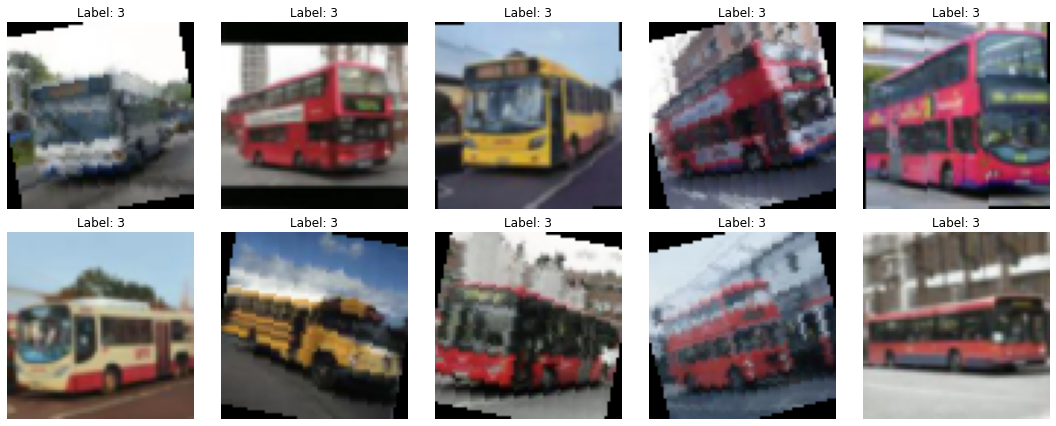

[Epoch 1/200] [Batch 0/20] [D loss: 0.7461] [G loss: 3.3878]
[Epoch 2/200] [Batch 0/20] [D loss: 0.0244] [G loss: 8.0166]
[Epoch 3/200] [Batch 0/20] [D loss: 0.0571] [G loss: 10.5609]
[Epoch 4/200] [Batch 0/20] [D loss: 0.0558] [G loss: 4.6289]
[Epoch 5/200] [Batch 0/20] [D loss: 0.0824] [G loss: 6.3128]
[Epoch 6/200] [Batch 0/20] [D loss: 0.3105] [G loss: 6.8270]
[Epoch 7/200] [Batch 0/20] [D loss: 0.1157] [G loss: 4.7304]
[Epoch 8/200] [Batch 0/20] [D loss: 0.1032] [G loss: 5.8286]
[Epoch 9/200] [Batch 0/20] [D loss: 0.0873] [G loss: 6.0349]
[Epoch 10/200] [Batch 0/20] [D loss: 0.3153] [G loss: 8.7671]
[Epoch 11/200] [Batch 0/20] [D loss: 0.0988] [G loss: 6.7233]
[Epoch 12/200] [Batch 0/20] [D loss: 0.0774] [G loss: 6.2807]
[Epoch 13/200] [Batch 0/20] [D loss: 0.0751] [G loss: 5.3957]
[Epoch 14/200] [Batch 0/20] [D loss: 0.2594] [G loss: 9.6091]
[Epoch 15/200] [Batch 0/20] [D loss: 0.1250] [G loss: 6.0350]
[Epoch 16/200] [Batch 0/20] [D loss: 0.0202] [G loss: 4.2996]
[Epoch 17/200] [

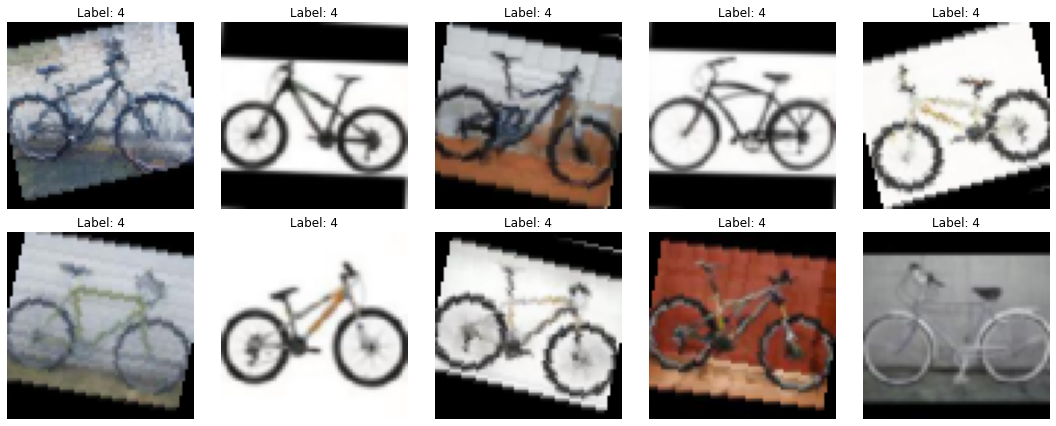

[Epoch 1/200] [Batch 0/24] [D loss: 0.7586] [G loss: 3.3900]
[Epoch 2/200] [Batch 0/24] [D loss: 0.0165] [G loss: 9.0799]
[Epoch 3/200] [Batch 0/24] [D loss: 0.3488] [G loss: 13.5025]
[Epoch 4/200] [Batch 0/24] [D loss: 0.6058] [G loss: 11.4382]
[Epoch 5/200] [Batch 0/24] [D loss: 0.2065] [G loss: 4.2277]
[Epoch 6/200] [Batch 0/24] [D loss: 0.2273] [G loss: 4.8353]
[Epoch 7/200] [Batch 0/24] [D loss: 0.0962] [G loss: 4.0233]
[Epoch 8/200] [Batch 0/24] [D loss: 0.0748] [G loss: 5.0063]
[Epoch 9/200] [Batch 0/24] [D loss: 0.1369] [G loss: 7.9215]
[Epoch 10/200] [Batch 0/24] [D loss: 0.2170] [G loss: 9.2781]
[Epoch 11/200] [Batch 0/24] [D loss: 0.0544] [G loss: 5.0894]
[Epoch 12/200] [Batch 0/24] [D loss: 0.7067] [G loss: 3.6493]
[Epoch 13/200] [Batch 0/24] [D loss: 0.0725] [G loss: 5.9255]
[Epoch 14/200] [Batch 0/24] [D loss: 0.0250] [G loss: 4.4499]
[Epoch 15/200] [Batch 0/24] [D loss: 0.0949] [G loss: 5.4965]
[Epoch 16/200] [Batch 0/24] [D loss: 0.1828] [G loss: 3.3764]
[Epoch 17/200] 

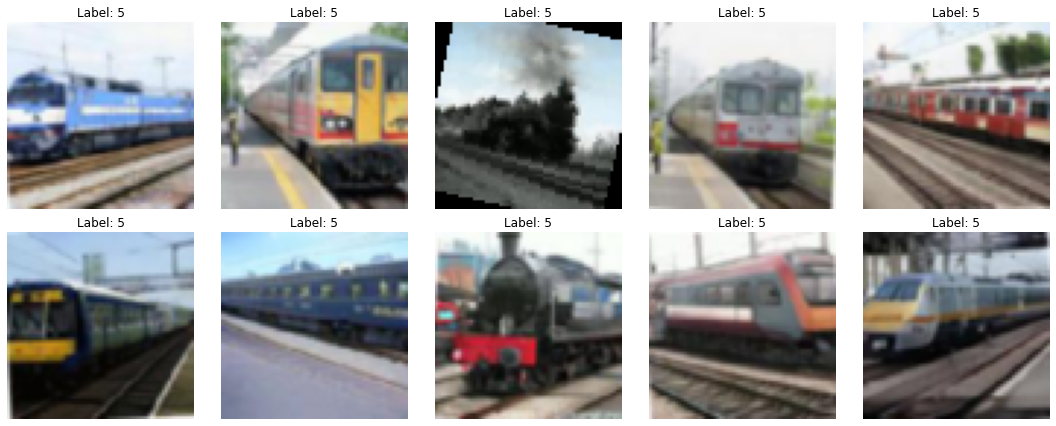

[Epoch 1/200] [Batch 0/19] [D loss: 0.7898] [G loss: 3.6257]
[Epoch 2/200] [Batch 0/19] [D loss: 0.0446] [G loss: 8.4899]
[Epoch 3/200] [Batch 0/19] [D loss: 0.0062] [G loss: 5.8682]
[Epoch 4/200] [Batch 0/19] [D loss: 0.0368] [G loss: 6.1100]
[Epoch 5/200] [Batch 0/19] [D loss: 0.0250] [G loss: 16.6261]
[Epoch 6/200] [Batch 0/19] [D loss: 0.6050] [G loss: 12.3587]
[Epoch 7/200] [Batch 0/19] [D loss: 0.2811] [G loss: 2.7225]
[Epoch 8/200] [Batch 0/19] [D loss: 0.2058] [G loss: 3.5495]
[Epoch 9/200] [Batch 0/19] [D loss: 0.3690] [G loss: 5.2511]
[Epoch 10/200] [Batch 0/19] [D loss: 0.1025] [G loss: 3.6406]
[Epoch 11/200] [Batch 0/19] [D loss: 0.1731] [G loss: 3.8068]
[Epoch 12/200] [Batch 0/19] [D loss: 0.2218] [G loss: 4.1153]
[Epoch 13/200] [Batch 0/19] [D loss: 0.0863] [G loss: 4.3998]
[Epoch 14/200] [Batch 0/19] [D loss: 0.1088] [G loss: 2.7862]
[Epoch 15/200] [Batch 0/19] [D loss: 0.3384] [G loss: 5.9732]
[Epoch 16/200] [Batch 0/19] [D loss: 0.1713] [G loss: 3.5572]
[Epoch 17/200] 

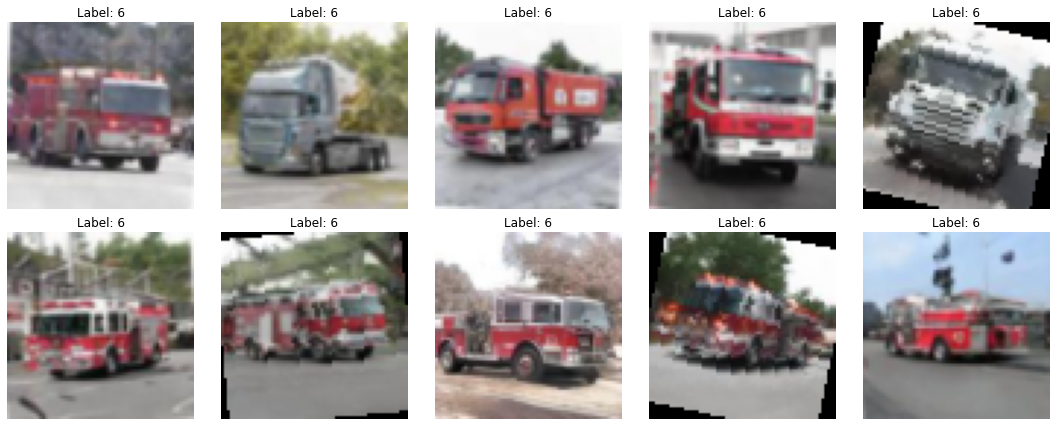

[Epoch 1/200] [Batch 0/52] [D loss: 0.7461] [G loss: 3.9074]
[Epoch 1/200] [Batch 32/52] [D loss: 0.0547] [G loss: 8.3589]
[Epoch 2/200] [Batch 0/52] [D loss: 0.0305] [G loss: 5.6774]
[Epoch 2/200] [Batch 32/52] [D loss: 0.1211] [G loss: 7.5730]
[Epoch 3/200] [Batch 0/52] [D loss: 0.1219] [G loss: 4.6184]
[Epoch 3/200] [Batch 32/52] [D loss: 0.1775] [G loss: 5.6013]
[Epoch 4/200] [Batch 0/52] [D loss: 0.1423] [G loss: 4.1751]
[Epoch 4/200] [Batch 32/52] [D loss: 0.0484] [G loss: 4.6891]
[Epoch 5/200] [Batch 0/52] [D loss: 0.9152] [G loss: 8.2226]
[Epoch 5/200] [Batch 32/52] [D loss: 0.1354] [G loss: 8.2447]
[Epoch 6/200] [Batch 0/52] [D loss: 0.5643] [G loss: 9.0517]
[Epoch 6/200] [Batch 32/52] [D loss: 0.0647] [G loss: 6.4151]
[Epoch 7/200] [Batch 0/52] [D loss: 0.0992] [G loss: 5.8529]
[Epoch 7/200] [Batch 32/52] [D loss: 0.1055] [G loss: 4.9740]
[Epoch 8/200] [Batch 0/52] [D loss: 0.0320] [G loss: 4.7465]
[Epoch 8/200] [Batch 32/52] [D loss: 0.0922] [G loss: 5.7474]
[Epoch 9/200] [B

In [ ]:
##Train
for class_name in classes:
    # initialize hyperParameters
    noise_size = 100      
    latent_dim = 100
    input_size = 64
    batch_size = 16          
    num_epochs = 200         
    learning_rate = 0.0002
    
    # Generator와 Discriminator 초기화
    generator = Generator().to(DEVICE)
    generator.apply(weights_init)

    discriminator = Discriminator().to(DEVICE)

    # 손실 함수와 최적화 알고리즘
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    save_path = make_synthesize_img(class_name)
    train_loader = make_dataset(class_name)
    # 샘플 확인
    show_samples_from_loader(train_loader, num_samples=10, cols=5)
    
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(train_loader):
            real_imgs = real_imgs.to(DEVICE)
            batch_size = real_imgs.size(0)

            valid = torch.ones((batch_size, 1, 1, 1), device=DEVICE)
            fake = torch.zeros((batch_size, 1, 1, 1), device=DEVICE)

            # 1. Discriminator 학습
            optimizer_D.zero_grad()

            # 진짜 이미지에 대한 손실
            real_loss = criterion(discriminator(real_imgs), valid)

            # 가짜 이미지에 대한 손실
            z = torch.randn(batch_size, noise_size, 1, 1, device=DEVICE)
            fake_imgs = generator(z)
            fake_loss = criterion(discriminator(fake_imgs.detach()), fake)  # detach() 사용

            # Discriminator 총 손실
            loss_D = (real_loss + fake_loss) / 2
            loss_D.backward()
            optimizer_D.step()

            # 2. Generator 학습
            optimizer_G.zero_grad()

            # Generator 손실 (Discriminator가 진짜로 판단하도록 학습)
            loss_G = criterion(discriminator(fake_imgs), valid)
            loss_G.backward(retain_graph=False)  # retain_graph=False로 기본 설정
            optimizer_G.step()

            # 진행 상태 출력
            if i % 32 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

            # Save generated images
            if i % 32 == 0:  # Save every 32 batches
                z = torch.randn(batch_size, latent_dim, 1, 1, device=DEVICE)
                gen_imgs = generator(z)
                for j in range(gen_imgs.size(0)):
                    file_name = f"{i * batch_size + j}.png"
                    file_path = os.path.join(save_path, file_name)
                    save_image(0.5 * gen_imgs[j] + 0.5, file_path)  # Unnormalize and save